# Casadi example - velocity optimization/velocity planning problem

$\min\limits_{a} dt \sum\limits_{k=1}^N{v_k}$

s.t. $a_{min}<a_k<=a_{max} \forall k=1\dots N$

$0<v_k<=v_{max,k} \forall k=1\dots N$

$v_{k+1}=v_k + a_k dt \forall k=1\dots N-1$

$v_0=1, v_N=1, a_0=0$

$a  \in \R^N, v \in \R^{N+1}$

with parameters $a_{min}, a_{max}, v_{max}$ and decision variable $a \in R^N$

For simplicity, the velocity vector is constant, such that the problem can be parametrized by 3 scalar parameters $v_{max}, a_{max}, a_{min}$

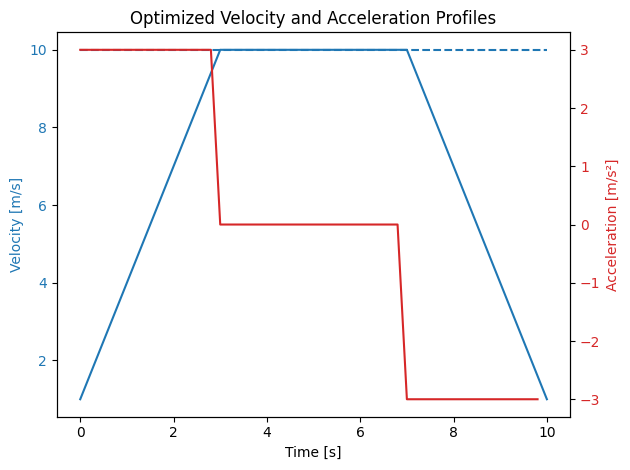

In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 50
T = 10.0
dt = T / N
v_max = 10.0*np.ones(N+1)
#v_max[25:] = 5.0
a_max = 3.0
a_min = -3.0

def velocity_planner(v_max, a_max, a_min, opti_silent=False):
    opti = ca.Opti()
    v = opti.variable(N+1)
    a = opti.variable(N)
    v_max_opti =  opti.parameter(N+1)
    a_max_opti =  opti.parameter(1)
    a_min_opti =  opti.parameter(1)

    opti.subject_to(v[0] == 1.0)
    for k in range(N):
        opti.subject_to(v[k+1] == v[k] + dt * a[k])

    opti.subject_to(opti.bounded(0.01, v, v_max_opti))
    opti.subject_to(opti.bounded(a_min_opti, a, a_max_opti))
    opti.subject_to(v[N] == 1.0)

    distance = ca.sum1(v) * dt
    opti.minimize(-distance + ca.sum1(a*a)*0.0)

    if opti_silent:
        p_opts = {'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}
        #p_opts = {'print_time':False, 'verbose':False}
        s_opts = {'print_level':0}
    else:
        p_opts = {}
        s_opts = {}

    opti.solver('ipopt',p_opts,s_opts)

    opti.set_value(v_max_opti, v_max)
    opti.set_value(a_max_opti, a_max)
    opti.set_value(a_min_opti, a_min)

    return opti, v, a

opti, v, a = velocity_planner(v_max, a_max, a_min, opti_silent=True)
sol = opti.solve()

v_opt = sol.value(v)
a_opt = sol.value(a)
time = np.linspace(0, T, N+1)

# Plotting
fig, ax1 = plt.subplots()
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Velocity [m/s]', color='tab:blue')
ax1.plot(time, v_opt, color='tab:blue')
ax1.plot(time, v_max, color='tab:blue', linestyle='--', label='Max Velocity')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Acceleration [m/s²]', color='tab:red')
ax2.plot(time[:-1], a_opt, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Optimized Velocity and Acceleration Profiles')
plt.tight_layout()
plt.show()


as expected, due to the simple formulation, the optimal (time optimal as we maximize the driven distance in a given time horizon) solution is to accelerate and decelerate with the max. allowed acceleration/deceleration but still consider the equality constraints at begin and end of the interval

# neuromancer version

aim is now, to formulate the problem above into neuromancer, the neuromancer Part_1_basics.ipynb was used as baseline for that.

In [2]:
import torch
import torch.nn as nn
from neuromancer.constraint import variable
from neuromancer.system import Node, System
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.dataset import DictDataset
from neuromancer.modules import blocks
import neuromancer.slim as slim

data_seed = 408  # random seed used for simulated data
np.random.seed(data_seed)
torch.manual_seed(data_seed)

/home/martgro1/neuromancer/.venv/lib/python3.10/site-packages/mlflow/utils/requirements_utils.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


randomly generate data

parameters v_max, a_min, a_max randomly within meaningful range

Note: v_max is a scalar value here as the simple case of having a constant speed limit along the horizon (length $N$ time steps) is considered

In [3]:
nsim = 5000
samples_train = {
    "v_max": torch.FloatTensor(nsim, 1).uniform_(10, 15),
    "a_max": torch.FloatTensor(nsim, 1).uniform_(1.0, a_max),
    "a_min": torch.FloatTensor(nsim, 1).uniform_(a_min, -1.0),
}
samples_dev = {
    "v_max": torch.FloatTensor(nsim, 1).uniform_(10, 15),
    "a_max": torch.FloatTensor(nsim, 1).uniform_(1.0, a_max),
    "a_min": torch.FloatTensor(nsim, 1).uniform_(a_min, -1.0),
}
samples_test = {
    "v_max": torch.FloatTensor(nsim, 1).uniform_(10, 15),
    "a_max": torch.FloatTensor(nsim, 1).uniform_(1.0, a_max),
    "a_min": torch.FloatTensor(nsim, 1).uniform_(a_min, -1.0),
}

# create named dictionary datasets
train_data = DictDataset(samples_train, name='train')
dev_data = DictDataset(samples_dev, name='dev')
test_data = DictDataset(samples_test, name='test')
# create torch dataloaders for the Trainer
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0,
                                           collate_fn=train_data.collate_fn, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=32, num_workers=0,
                                         collate_fn=dev_data.collate_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, num_workers=0,
                                         collate_fn=test_data.collate_fn, shuffle=True)

[[11.864613]
 [11.676646]
 [10.085791]
 ...
 [13.062795]
 [11.743557]
 [12.93798 ]]


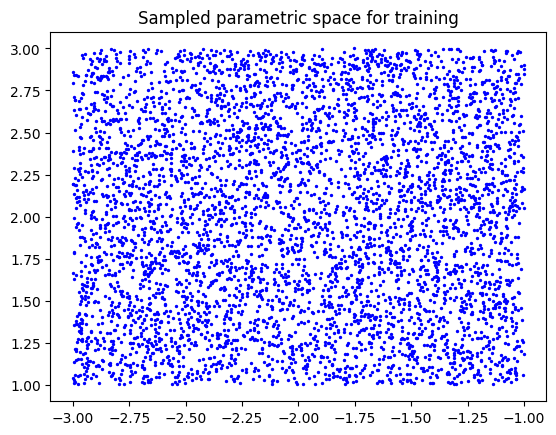

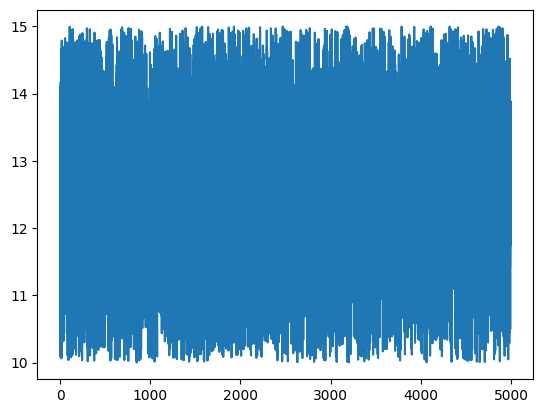

In [4]:
a_max_train = samples_train['a_max'].numpy()
a_min_train = samples_train['a_min'].numpy()

plt.figure()
plt.scatter(a_min_train, a_max_train, s=2., c='blue', marker='o')
plt.title('Sampled parametric space for training')

v_max_train = samples_train['v_max'].numpy()
print(v_max_train)
plt.figure()
plt.plot(v_max_train)

define the neural network (sol_map):

(v_min, a_max, a_min) --> sol_map --> (state)

The neural network should map the 3 scalar inputs (the 3 parameters) to the solution of the velocity planning problem where the output (vector, dimension $2*N$) state contains the velocity $v$ ($0:N$) and acceleration $a$ ($N:2*N$) accordingly


In [5]:

''' just for debugging
class DebugMLP(nn.Module):
    def __init__(self, mlp, N):
        super().__init__()
        self.mlp = mlp
        self.N = N

    def forward(self, *inputs):
        x = torch.cat(inputs, dim=-1)  # Concatenate v_max, a_max, a_min
        out = self.mlp(x)              # shape: [batch_size, 2*N]
        print("state shape:", out.shape)
        v = out[:, :self.N]
        a = out[:, self.N:]
        print("v shape:", v.shape)
        print("a shape:", a.shape)
        return out  # return full state


mlp = blocks.MLP(insize=3, outsize=2*N,
                bias=True,
                linear_map=slim.maps['linear'],
                nonlin=nn.ReLU,
                hsizes=[80] * 4)

func = DebugMLP(mlp, N)
sol_map = Node(func, ['v_max', 'a_max', 'a_min'], ['state'], name='sol_map')
'''
func = blocks.MLP(insize=3, outsize=2*N,
                bias=True,
                linear_map=slim.maps['linear'],
                nonlin=nn.ReLU,
                hsizes=[120] * 6)
sol_map = Node(func, ['v_max', 'a_max', 'a_min'], ['state'], name='sol_map')

In [6]:
v = variable("state")[:, 0:N]
a = variable("state")[:, N:2*N]
v_max_var = variable("v_max")
a_max_var = variable("a_max")
a_min_var = variable("a_min")

# Dynamics constraint: v[k+1] = v[k] + dt * a[k]
def dynamics(v, a):
    return v + dt * a

# Constraints
con_dyn = (v[:,1:] == v[:,0:-1] + dt* a[:,0:-1])#dynamics(v[:,0:-1], a[:,0:-1]))
#con_dyn = (v[:,1] == v[:,0] + dt* a[:,0])#dynamics(v[:,0:-1], a[:,0:-1]))
con_dyn.name = 'con_dyn'
con_v_lower = ( 0.01 * torch.ones_like(v) <= v)
con_v_lower.name = 'con_v_lower'
con_v_upper = (v <= v_max_var*torch.ones_like(v))
con_v_upper.name = 'con_v_upper'
con_a_lower = (a_min_var*torch.ones_like(a) <= a)
con_a_lower.name = 'con_a_lower'
con_a_upper = (a <= a_max_var*torch.ones_like(a))
con_a_upper.name = 'con_a_upper'

con_v0 = (v[:, 0] == 1.0 * torch.ones_like(v[:, 0]))
con_v0.name = 'con_v0'
con_vN = (v[:, -1] == 1.0 * torch.ones_like(v[:, -1]))
con_vN.name = 'con_vN'

# Objective: maximize distance → minimize -sum(v) * dt
objective = (-torch.sum(v) * dt).minimize(name='distance')

# Problem
constraints = [con_dyn, con_v_lower, con_v_upper, con_a_lower, con_a_upper, con_v0, con_vN]
loss = PenaltyLoss(objectives=[objective], constraints=constraints)
problem = Problem([sol_map], loss=loss)

In [7]:
lr = 0.00001      # step size for gradient descent
epochs = 100    # number of training epochs
warmup = 10    # number of epochs to wait before enacting early stopping policy
patience = 10  # number of epochs with no improvement in eval metric to allow before early stopping

In [8]:
# Trainer
optimizer = torch.optim.AdamW(problem.parameters(), lr=lr)

# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=epochs,
    patience=patience,
    warmup=warmup)


In [9]:
# Train NLP solution map
best_model = trainer.train()
best_outputs = trainer.test(best_model)
problem.load_state_dict(best_model)

epoch: 0  train_loss: -4.367648601531982
epoch: 1  train_loss: -20.720998764038086
epoch: 2  train_loss: -69.9765396118164
epoch: 3  train_loss: -182.04942321777344
epoch: 4  train_loss: -412.97265625
epoch: 5  train_loss: -854.3319091796875
epoch: 6  train_loss: -1626.2757568359375
epoch: 7  train_loss: -2901.798095703125
epoch: 8  train_loss: -4911.51806640625
epoch: 9  train_loss: -7934.009765625
epoch: 10  train_loss: -12317.8583984375
epoch: 11  train_loss: -18509.703125
epoch: 12  train_loss: -27029.69140625
epoch: 13  train_loss: -38561.84375
epoch: 14  train_loss: -53868.4921875
Interrupted training loop.


<All keys matched successfully>

In [10]:
# Solution to via Neuromancer
datapoint = {'v_max': torch.tensor([[7.5]]), 'a_max': torch.tensor([[2.5]]), 'a_min': torch.tensor([[-2]]),
             'name': 'test'}
model_out = problem(datapoint)
v_nm = model_out['test_' + "state"][0, 0:N].detach().numpy()
a_nm = model_out['test_' + "state"][0, N:2*N].detach().numpy()
print(v_nm)
print(a_nm)

[133.05965  142.67935  129.59349  122.001595  95.658806  97.51279
 138.47577  171.38182   83.63018  138.55492   82.8409   168.7831
 120.81103  105.31463  100.158226 174.64322   91.27242  171.59143
 143.77905  161.98366  147.2578   127.06798  126.25329  117.13154
 111.48557  110.50016   87.67903  125.38473  108.558266  87.13674
  91.18233  154.88297  136.86679  114.64664  104.17758   92.70902
 119.99723   98.09807  162.93504  122.69983  139.84677  135.02922
  66.72937  176.14273  133.0263   160.24268  100.98559   59.82623
 109.50754  117.33674 ]
[ 0.83384115 -0.875126   -0.8865153  -0.8843765   0.8857564   0.8913892
  0.8796276  -0.90084314  0.7888266  -0.90261495  0.9697767  -0.88516545
 -0.8533633  -0.92381257  0.86748755 -0.9465971   0.8894771  -0.89636475
  0.8408693  -0.90129507 -0.8896405  -0.9172927  -0.9067938  -0.9153616
 -0.89708495 -0.89649826  0.85955137 -0.8996904  -0.88117814  0.8009302
  0.891306   -0.8625131  -0.88784456 -0.91274816 -0.8892435   0.78783566
 -0.98600733  

it seems, neuromancer does not consider e.g. the equality constraints at the beginning and end of the interval, so the solution is not valid.

the values in the velocity vector grow up to unplausible value ranges.